# Modeling: Hyper Parameter Search

In [1]:
%%time
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
random.seed(42)
import xgboost as xgb
print("XGBoost version:", xgb.__version__)
print("XGBoost config:", xgb.get_config())
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import r2_score, mean_squared_error
from tqdm.notebook import tqdm
import joblib
import warnings
import gc

save_dir = "/root/autodl-tmp"

XGBoost version: 2.0.3
XGBoost config: {'use_rmm': False, 'verbosity': 1}
CPU times: user 1.92 s, sys: 986 ms, total: 2.9 s
Wall time: 3.22 s


In [2]:
%%time

# Load the dataset
df_train = pd.read_parquet("data/prep/data_train.parquet")
df_valid = pd.read_parquet("data/prep/data_valid.parquet")
df_test = pd.read_parquet("data/prep/data_test.parquet")
    
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 968789 entries, 0 to 968788
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         968789 non-null  object 
 1   vendor_id                  968789 non-null  int64  
 2   passenger_count            968789 non-null  int64  
 3   store_and_fwd_flag         968789 non-null  int64  
 4   pickup_pca0                968789 non-null  float64
 5   pickup_pca1                968789 non-null  float64
 6   dropoff_pca0               968789 non-null  float64
 7   dropoff_pca1               968789 non-null  float64
 8   geodesic_distance          968789 non-null  float64
 9   pickup_hour_of_day         968789 non-null  int32  
 10  day_of_week                968789 non-null  int64  
 11  hour_of_week               968789 non-null  int64  
 12  month_of_year              968789 non-null  int64  
 13  day_of_year                96

In [3]:
%%time
    
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121099 entries, 0 to 121098
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         121099 non-null  object 
 1   vendor_id                  121099 non-null  int64  
 2   passenger_count            121099 non-null  int64  
 3   store_and_fwd_flag         121099 non-null  int64  
 4   pickup_pca0                121099 non-null  float64
 5   pickup_pca1                121099 non-null  float64
 6   dropoff_pca0               121099 non-null  float64
 7   dropoff_pca1               121099 non-null  float64
 8   geodesic_distance          121099 non-null  float64
 9   pickup_hour_of_day         121099 non-null  int32  
 10  day_of_week                121099 non-null  int64  
 11  hour_of_week               121099 non-null  int64  
 12  month_of_year              121099 non-null  int64  
 13  day_of_year                12

In [4]:
%%time

# Select X (second column to second last column) and y (last column)
X_train = df_train.iloc[:, 1:-1].values
y_train = np.log(df_train.iloc[:, -1].values + 1)  # Apply log transformation
X_valid = df_valid.iloc[:, 1:-1].values
y_valid = np.log(df_valid.iloc[:, -1].values + 1)  # Apply log transformation
X_test = df_test.iloc[:, 1:-1].values
y_test = np.log(df_test.iloc[:, -1].values + 1)  # Apply log transformation

# Convert datasets into XGBoost DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)
dtest = xgb.DMatrix(X_test, label=y_test)

# Verify conversion
print("DMatrix dtrain:", dtrain.num_row(), "rows,", dtrain.num_col(), "columns")
print("DMatrix dvalid:", dvalid.num_row(), "rows,", dvalid.num_col(), "columns")
print("DMatrix dtest:", dtest.num_row(), "rows,", dtest.num_col(), "columns")

# Cleanup
del df_train, df_valid, df_test
gc.collect()

DMatrix dtrain: 968789 rows, 32 columns
DMatrix dvalid: 121099 rows, 32 columns
DMatrix dtest: 121099 rows, 32 columns
CPU times: user 1.9 s, sys: 569 ms, total: 2.47 s
Wall time: 1.03 s


0

In [5]:
%%time

# Define parameter grid for Hyper Parameter Search
param_dist = {
    "max_depth": [3, 5, 7, 9, 11, 13],
    "eta": [0.01, 0.05, 0.1, 0.3, 0.5],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.1, 0.3, 0.5, 0.7, 0.9], 
    "min_child_weight": [1, 2, 5, 10, 20, 50, 100],
    "gamma": [0.1, 0.25, 0.5, 1, 2, 5],
    "reg_lambda": [0, 0.01, 0.1, 1, 5, 10, 100],  # L2 regularization
    "reg_alpha": [0, 0.01, 0.1, 1, 5, 10, 100],  # L1 regularization
}

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 16.9 µs


In [6]:
%%time

# Sample parameter combinations from the parameter grid
param_samples = list(ParameterSampler(param_dist, n_iter=2500, random_state=42))

# Initialize storage for performance metrics
test_performance = {key: [] for key in list(param_samples[0].keys())
                    + ["train_rmsle", "valid_rmsle", "test_rmsle",
                       "train_r2score", "valid_r2score", "test_r2score"]}
best_rmsle_valid = float("inf")
best_model = None

# Define the evaluation set
eval_set = [(dtrain, "train"), (dvalid, "valid")]

# Define the base parameters
base_params = {
    "nthread": 4,
    "device": "cuda",
    "tree_method": "hist",
    "booster": "gbtree",
    "eval_metric": "rmse",
    "objective": "reg:squarederror",
    "random_state": 42,
}

CPU times: user 33.3 ms, sys: 0 ns, total: 33.3 ms
Wall time: 32.2 ms


In [7]:
%%time

# Iterate over each parameter combination
for params in tqdm(param_samples, desc="Hyperparameter Search Progress...", leave=False):
    # Merge base parameters with current set of hyperparameters
    current_params = {**base_params, **params}
    
    # Train the model
    model = xgb.train(
        params=current_params,
        dtrain=dtrain,
        num_boost_round=5000,
        evals=eval_set,
        early_stopping_rounds=50,
        verbose_eval=False,
    )
    
    # Make predictions
    y_pred_train = model.predict(dtrain)
    y_pred_valid = model.predict(dvalid)
    y_pred_test = model.predict(dtest)
    
    # Calculate R^2 scores
    train_score = r2_score(y_train, y_pred_train, force_finite=False)
    valid_score = r2_score(y_valid, y_pred_valid, force_finite=False)
    test_score = r2_score(y_test, y_pred_test, force_finite=False)
    
    # Calculate RMSLE(RMSE & log(Y))
    # RMSE for train, validation, and test sets
    train_rmsle = np.sqrt(mean_squared_error(y_train, y_pred_train))
    valid_rmsle = np.sqrt(mean_squared_error(y_valid, y_pred_valid))
    test_rmsle = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    # Append parameter values and RMSE scores
    for param in params.keys():
        test_performance[param].append(params[param])
    
    test_performance["train_rmsle"].append(train_rmsle)
    test_performance["valid_rmsle"].append(valid_rmsle)
    test_performance["test_rmsle"].append(test_rmsle)
    test_performance["train_r2score"].append(train_score)
    test_performance["valid_r2score"].append(valid_score)
    test_performance["test_r2score"].append(test_score)
    
    # Update best model based on validation RMSLE
    if valid_rmsle < best_rmsle_valid:
        best_rmsle_valid = valid_rmsle
        best_model = model

# Cleanup memory
gc.collect()

Hyperparameter Search Progress...:   0%|          | 0/2500 [00:00<?, ?it/s]

CPU times: user 7h 8min 31s, sys: 8h 27min 46s, total: 15h 36min 17s
Wall time: 15h 33min 22s


455

In [8]:
%%time

# Generate folders to save model outputs
os.makedirs("model", exist_ok=True)

# Generate a DataFrame to store performance results
performance_df = pd.DataFrame(test_performance)

# Find the parameter combination with the lowest RMSLE on the test set
best_params_valid = performance_df.loc[
    performance_df["valid_rmsle"].idxmin()].to_dict()

print("Best parameters valid set: ",
      best_params_valid)
print("Best RMSE on test set: ",
      best_rmsle_valid)

# Save the best model to file
best_model.save_model(os.path.join("model", "best_model_found_validation.json"))

# Optionally, save the performance DataFrame to a CSV file
performance_df.to_csv(os.path.join("model", "hyperparameter_search_results.csv"),
                      index=False)

Best parameters valid set:  {'subsample': 0.7, 'reg_lambda': 0.01, 'reg_alpha': 1.0, 'min_child_weight': 5.0, 'max_depth': 13.0, 'gamma': 0.1, 'eta': 0.01, 'colsample_bytree': 0.7, 'train_rmsle': 0.17704770192233632, 'valid_rmsle': 0.22304535414955934, 'test_rmsle': 0.2224325787112704, 'train_r2score': 0.903435873487207, 'valid_r2score': 0.8466142631605973, 'test_r2score': 0.8474309875128977}
Best RMSE on test set:  0.22304535414955934
CPU times: user 4.76 s, sys: 856 ms, total: 5.61 s
Wall time: 5.41 s


CPU times: user 189 ms, sys: 4.59 ms, total: 194 ms
Wall time: 195 ms


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

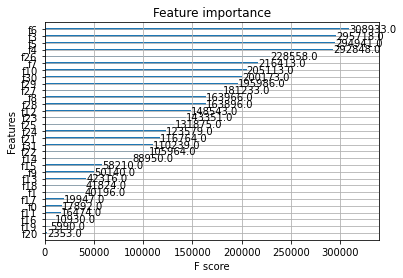

In [9]:
%%time

# Plot model importance
xgb.plot_importance(best_model)

In [10]:
%%time

# Find the row corresponding to the minimum RMSLE on validation and test sets
best_params_valid_rmsle = performance_df.loc[performance_df["valid_rmsle"].idxmin()].to_dict()
best_params_test_rmsle = performance_df.loc[performance_df["test_rmsle"].idxmin()].to_dict()

# Find the row corresponding to the maximum R² score on validation and test sets
best_params_valid_r2 = performance_df.loc[performance_df["valid_r2score"].idxmax()].to_dict()
best_params_test_r2 = performance_df.loc[performance_df["test_r2score"].idxmax()].to_dict()

# Print results with indentation
import json

print("Best Params Based on Validation RMSLE:")
print(json.dumps(best_params_valid_rmsle, indent=4))

print("\nBest Params Based on Test RMSLE:")
print(json.dumps(best_params_test_rmsle, indent=4))

print("\nBest Params Based on Validation R2:")
print(json.dumps(best_params_valid_r2, indent=4))

print("\nBest Params Based on Test R2:")
print(json.dumps(best_params_test_r2, indent=4))

Best Params Based on Validation RMSLE:
{
    "subsample": 0.7,
    "reg_lambda": 0.01,
    "reg_alpha": 1.0,
    "min_child_weight": 5.0,
    "max_depth": 13.0,
    "gamma": 0.1,
    "eta": 0.01,
    "colsample_bytree": 0.7,
    "train_rmsle": 0.17704770192233632,
    "valid_rmsle": 0.22304535414955934,
    "test_rmsle": 0.2224325787112704,
    "train_r2score": 0.903435873487207,
    "valid_r2score": 0.8466142631605973,
    "test_r2score": 0.8474309875128977
}

Best Params Based on Test RMSLE:
{
    "subsample": 0.7,
    "reg_lambda": 0.01,
    "reg_alpha": 1.0,
    "min_child_weight": 5.0,
    "max_depth": 13.0,
    "gamma": 0.1,
    "eta": 0.01,
    "colsample_bytree": 0.7,
    "train_rmsle": 0.17704770192233632,
    "valid_rmsle": 0.22304535414955934,
    "test_rmsle": 0.2224325787112704,
    "train_r2score": 0.903435873487207,
    "valid_r2score": 0.8466142631605973,
    "test_r2score": 0.8474309875128977
}

Best Params Based on Validation R2:
{
    "subsample": 0.7,
    "reg_lambd

In [11]:
%%time

# Load best parameters based on validation RMSLE
best_params = performance_df.loc[performance_df["valid_rmsle"].idxmin()].to_dict()

# Remove evaluation metrics from the dictionary (keep only hyperparameters)
best_params = {k: v for k, v in best_params.items() if k not in [
    "train_rmsle", "valid_rmsle", "test_rmsle",
    "train_r2score", "valid_r2score", "test_r2score"
]}

# Ensure 'max_depth' is an integer
if "max_depth" in best_params:
    best_params["max_depth"] = int(best_params["max_depth"])

# Define final model parameters
final_params = {
    "nthread": 4,
    "device": "cuda",
    "tree_method": "hist",
    "booster": "gbtree",
    "eval_metric": "rmse",
    "objective": "reg:squarederror",
    "random_state": 42,
    **best_params  # Inject best hyperparameters
}

# Train final model on full training set
final_model = xgb.train(
    final_params, dtrain, num_boost_round=5000,
    evals=[(dtest, "test")], # only be done after hyperparameter tuning
    early_stopping_rounds=50,
    verbose_eval=False
)

# Save model as JSON
final_model.save_model(os.path.join("model", "final_model.json"))

# Make predictions on train and test sets
y_train_pred = final_model.predict(dtrain)
y_test_pred = final_model.predict(dtest)

# Compute RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Compute R2 score
train_score = r2_score(y_train, y_pred_train, force_finite=False)
test_score = r2_score(y_test, y_pred_test, force_finite=False)

# Print results
results = {
    "Train RMSE": train_rmse,
    "Test RMSE": test_rmse,
    "Train R2": train_score,
    "Test R2": test_score
}

print(json.dumps(results, indent=4))

{
    "Train RMSE": 0.17704770192233632,
    "Test RMSE": 0.2224325787112704,
    "Train R2": 0.8110253786930113,
    "Test R2": 0.8085488790545294
}
CPU times: user 1min 27s, sys: 2min 18s, total: 3min 46s
Wall time: 3min 46s


CPU times: user 159 ms, sys: 7.45 ms, total: 166 ms
Wall time: 162 ms


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

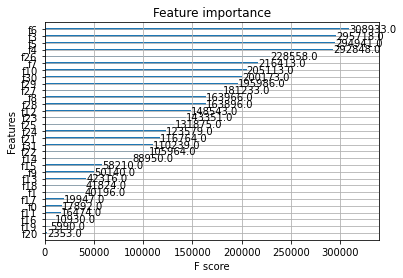

In [12]:
%%time

# Plot model importance
xgb.plot_importance(final_model)

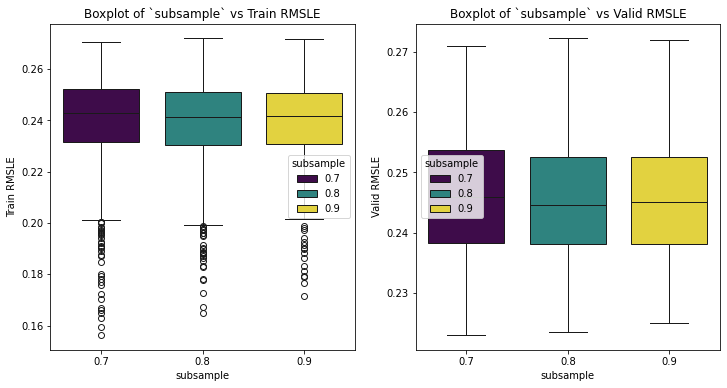

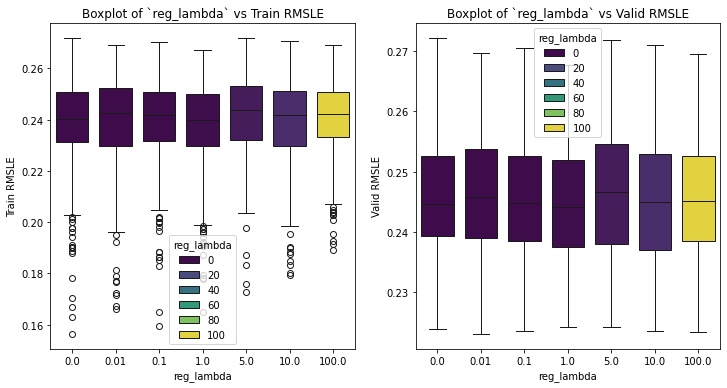

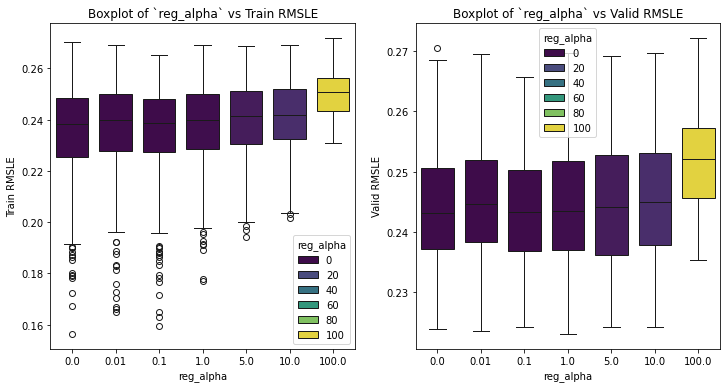

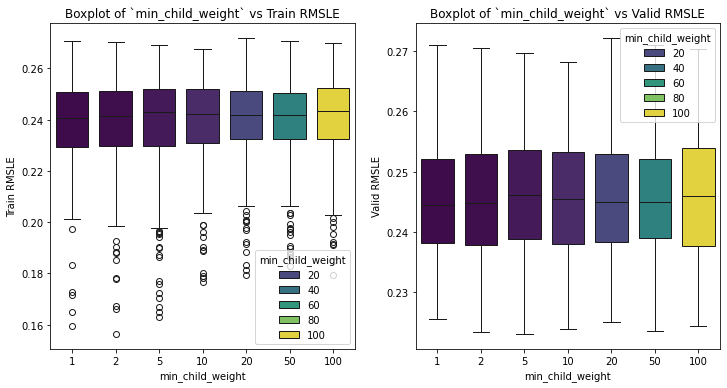

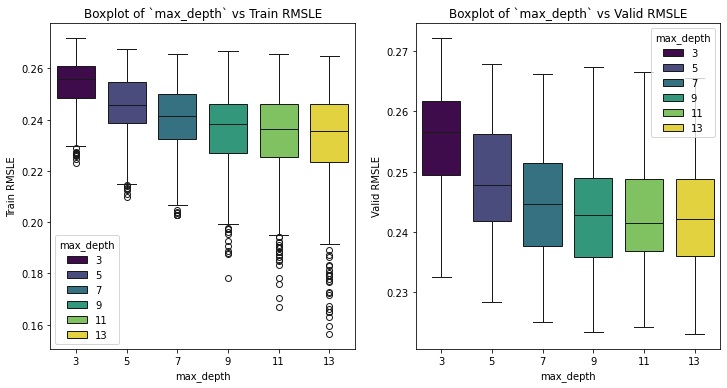

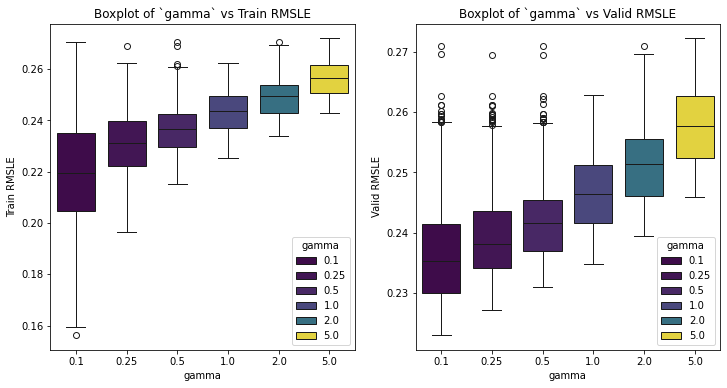

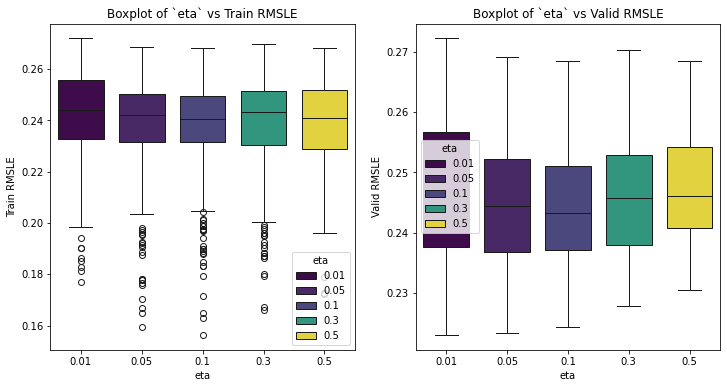

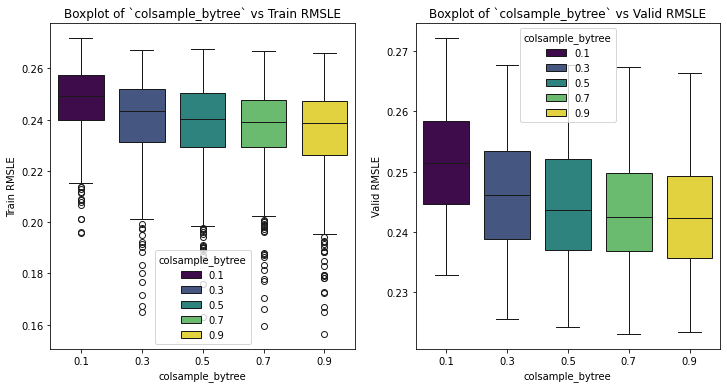

CPU times: user 5.77 s, sys: 877 ms, total: 6.65 s
Wall time: 5.2 s


In [13]:
%%time

# Iterate through each hyperparameter and create plots
for par in best_params.keys():
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    # Boxplot for train_rmsle vs hyperparameter
    sns.boxplot(x=par, y="train_rmsle", data=performance_df,
                ax=ax1, width=0.75, hue=par, palette="viridis")
    ax1.set_title(f"Boxplot of `{par}` vs Train RMSLE")
    ax1.set_xlabel(par)
    ax1.set_ylabel("Train RMSLE")

    # Boxplot for valid_rmsle vs hyperparameter
    sns.boxplot(x=par, y="valid_rmsle", data=performance_df,
                ax=ax2, width=0.75, hue=par, palette="viridis")
    ax2.set_title(f"Boxplot of `{par}` vs Valid RMSLE")
    ax2.set_xlabel(par)
    ax2.set_ylabel("Valid RMSLE")

    # Save the plot to the images folder
    fig.savefig(f"images/boxplot_{par}_rmsle.png")
    plt.show()
    plt.close(fig)

---